<a href="https://colab.research.google.com/github/RajendraPrasad96536/Image-Denoising-Algorithm-1/blob/master/Image%20Denoising%20Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
from tensorflow import keras
from keras.optimizers import RMSprop, Adagrad, Adam
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from keras.layers import Conv2DTranspose, BatchNormalization, add, LeakyReLU
from keras.models import Model
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
import keras.layers as layers
from keras.initializers import orthogonal

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
(cifar_train, _), (cifar_test, _) = cifar10.load_data()

In [3]:
size = 32
channel = 3
# scaling input data
cifar_train = cifar_train / 255
cifar_test = cifar_test / 255

# Adding noise mean = 0, std = 0.3
noise = 0.3
cifar_train_noise = cifar_train + noise * np.random.normal(0, 0.3, size=cifar_train.shape) 
cifar_test_noise = cifar_test + noise * np.random.normal(0, 0.3, size=cifar_test.shape)

cifar_train_noise = np.clip(cifar_train_noise, 0, 1)
cifar_test_noise = np.clip(cifar_test_noise, 0, 1)

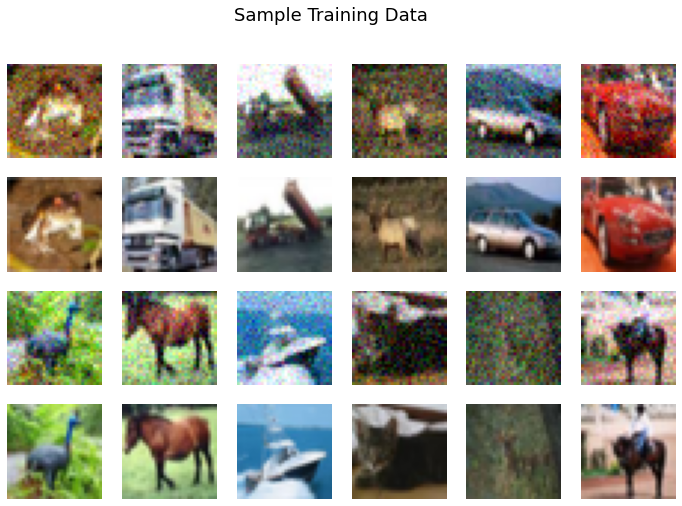

In [4]:
# Visualize few training images with their noisy images

rows = 2 # defining no. of rows in figure
cols = 6# defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train_noise[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train[i*cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data",fontsize=18)
plt.savefig("Cifar-trian.png")

plt.show()


In [5]:
inputs = Input(shape=(size,size,channel))
def Model_1():
  x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
  x = BatchNormalization()(x)
  x = MaxPool2D()(x)
  x = Dropout(0.5)(x)
  skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
  x = LeakyReLU()(skip)
  x = BatchNormalization()(x)
  x = MaxPool2D()(x)
  x = Dropout(0.5)(x)
  x = Conv2D(64, 3, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  encoded = MaxPool2D()(x)

  # Decoder
  x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Conv2DTranspose(32, 3, padding='same')(x)
  x = add([x,skip]) # adding skip connection
  x = LeakyReLU()(x)
  x = BatchNormalization()(x)
  decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)
  return decoded



def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x


def Model_2():

    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
  
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)
    
    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    skip4 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(skip4)

    return conv10


In [6]:
checkpoint = ModelCheckpoint('best_model_final.h5', verbose=1, save_best_only=True, save_weights_only=True)

In [7]:
# Encoder 
decoder = Model_2()

#decoder = Model_1()
model = Model(inputs, decoder)

""""
optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

optimizer = keras.optimizers.Adagrad(
    learning_rate=0.01,
    initial_accumulator_value=0.1,
    epsilon=1e-07
)
"""
#optimizer = Adam(lr=0.001,decay=0.001/80)
optimizer = keras.optimizers.Adamax(lr=0.001)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

#optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

#model_opt = Adam(lr_schedule)
model.compile(optimizer=optimizer,loss='mean_squared_error')
#model.compile(loss='mean_squared_error', optimizer = RMSprop())
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
block_1_conv (Conv2D)           (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block_1_lrelu (LeakyReLU)       (None, 32, 32, 64)   0           block_1_conv[0][0]               
__________________________________________________________________________________________________
block_1_drop (Dropout)          (None, 32, 32, 64)   0           block_1_lrelu[0][0]              
____________________________________________________________________________________________

In [ ]:
# Training
epochs = 50
batch_size = 128
history = model.fit(cifar_train_noise,
                cifar_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(cifar_test_noise, cifar_test),
                callbacks=[checkpoint]
               )

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 99s 2ms/step - loss: 0.0017 - val_loss: 0.0014

Epoch 00001: val_loss did not improve from 0.00138
Epoch 2/50
50000/50000 [==============================] - 99s 2ms/step - loss: 0.0017 - val_loss: 0.0014

Epoch 00002: val_loss improved from 0.00138 to 0.00137, saving model to best_model_final.h5
Epoch 3/50
50000/50000 [==============================] - 99s 2ms/step - loss: 0.0017 - val_loss: 0.0014

Epoch 00003: val_loss did not improve from 0.00137
Epoch 4/50
22016/50000 [============>.................] - ETA: 51s - loss: 0.0017

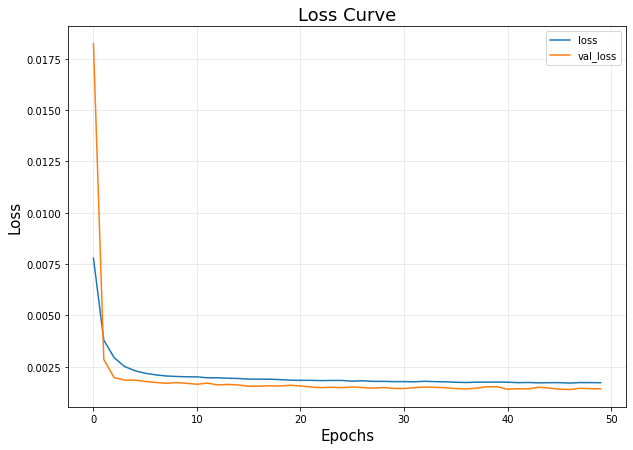

In [9]:
# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_cifar10.png")
plt.show()


In [10]:
def mse(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()

def PSNR(data_1, data_2):
    max_pixel = 1.0
    return 10.0 * (1.0 / math.log(10)) * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))


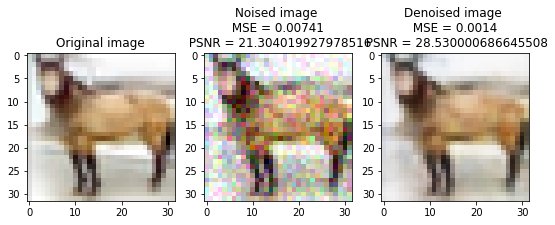

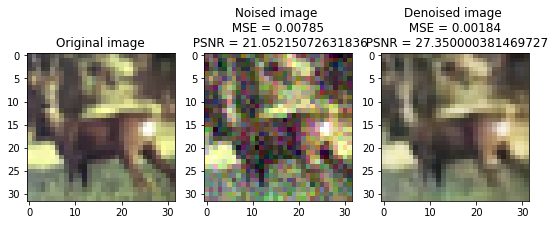

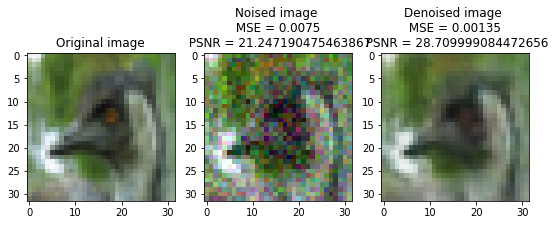

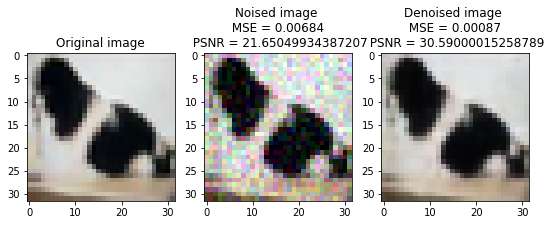

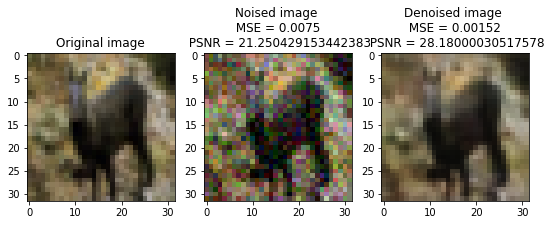

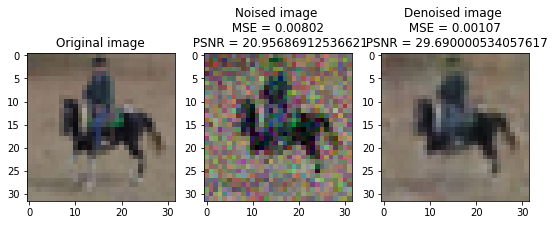

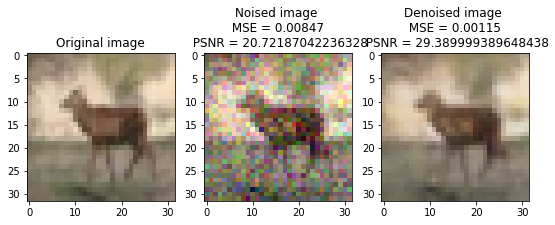

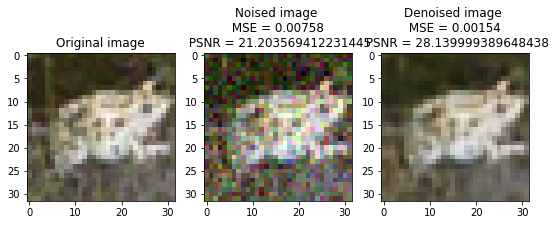

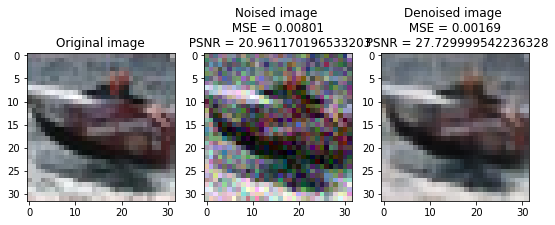

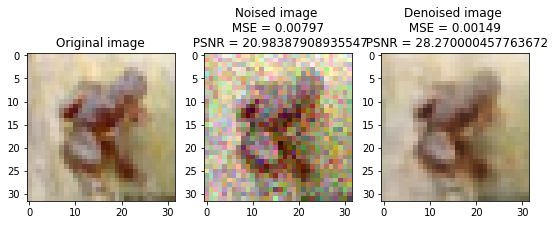

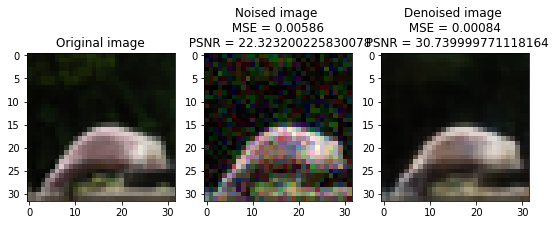

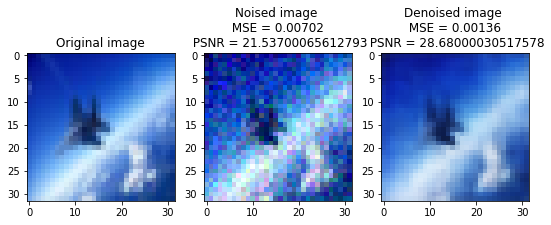

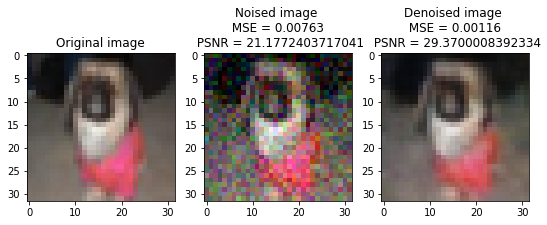

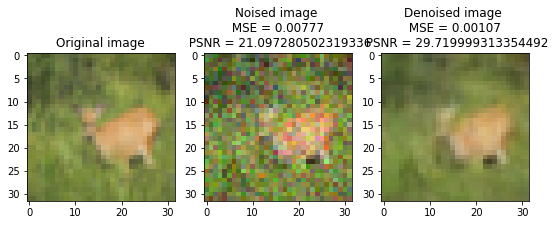

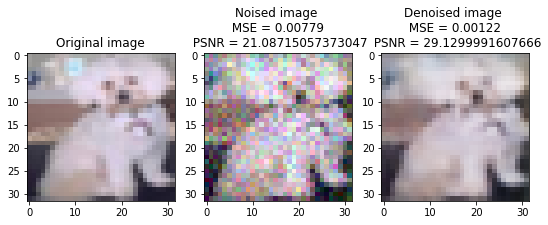

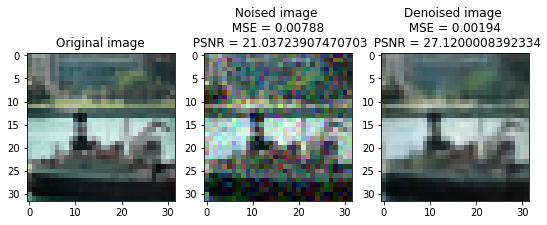

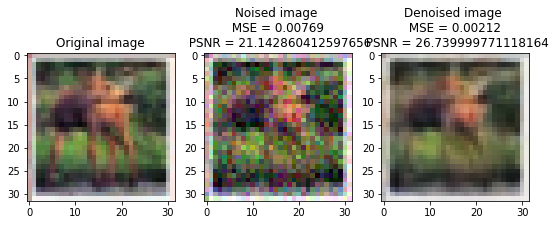

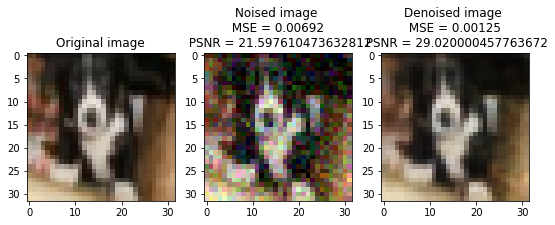

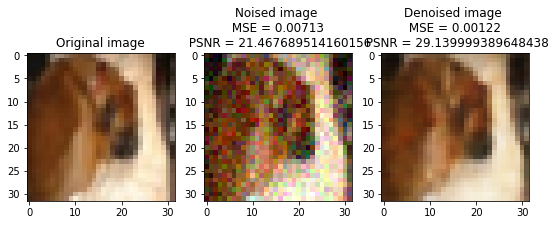

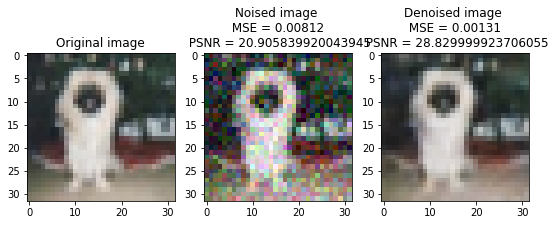

In [11]:
import random
import tensorflow as tf
for i in range(20):
  index = random.randint(0, 10000)
  orig_images = cifar_test[index] 
  noised_original = cifar_test_noise[index]
  noised_original_1 = noised_original.reshape(1,32,32,3)
  test_desoided = model.predict(noised_original_1)
  denoised_image  = test_desoided.reshape(32,32,3)

  import matplotlib.pyplot as plt 
  %matplotlib inline
  
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,3))

  axes[0].imshow(orig_images)
  axes[0].set_title('Original image')

  axes[1].imshow(noised_original)
  mse1 = round(mse(orig_images, noised_original), 5)
  psnr1 = round(tf.image.psnr(orig_images,noised_original,max_val=1.0).numpy(), 5)
  axes[1].set_title('Noised image \n MSE = {} \n PSNR = {}'.format(mse1, psnr1))
  mse2 = round(mse(denoised_image, orig_images), 5)
  psnr2 = round(tf.image.psnr(orig_images,denoised_image,max_val=1.0).numpy(), 2) 
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image \n MSE = {} \n PSNR = {}'.format(mse2, psnr2))
  plt.savefig("image"+str(i)+".png")
  plt.show()